In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cantidad_tiradas = 10000
numero_elegido = 11
cantidad_corridas = 10
apuesta_inicial = 5
capital_inicial = 10000
tipo_capital = 'i'
resultados_rojo = [1, 3, 5, 7, 9, 12, 14, 16,18, 19, 21, 23, 25, 27, 30, 32, 34, 36]
frec_relativa_esperada = 18/37 # apostando al rojo, 18 numeros rojos de 37

serie_fibonacci = [1, 1]
indice_fibonacci = 0

# estrategia = 'f'
estrategia = 'o' # o: otra - en este caso martingala invertida
# estrategia = 'd'
# estrategia = 'm'

In [112]:
estrategias = {
    'f': {
        'title': f'ESTRATEGIA FIBONACCI',
    },
    'm': {
        'title': f'ESTRATEGIA MARTINGALA',
    },
    'd': {
        'title': f'ESTRATEGIA DALEMBERT',
    },
    'o': {
        'title': f'ESTRATEGIA MARGINGALA INVERTIDA',
    },
}

El sistema D’Alembert es realmente sencillo, especialmente en contraste con estrategias como Labouchere, por ejemplo.
La idea principal es bastante similar a la clásica Martingala, pero con una diferencia importante – la apuesta progresiva

en el método de D’Alembert es mucho más plana que la duplicación agresiva de la Martingala. Como resultado esto da
lugar a una de las estrategias de ruleta más seguras y más fáciles de ejecutar.
El sistema está diseñado para funcionar para apuestas que tienen una probabilidad de ganar del 50% – las apuestas
llamadas “iguales”. Estas incluyen Rojo/Negro, Par/Impar, y 1-18/19-36. La lógica es que estas apuestas con el tiempo
se igualan – las rachas con resultados en rojo son seguidas por rachas ganadoras de apuestas en negro. También es
posible utilizar esta técnica con otros tipos de apuesta, aunque la forma más común sea con apuestas "iguales".
Es necesario determinar una “unidad” que será la columna vertebral de la estrategia D’Alembert. Puede ser una ficha o
una cantidad de dinero que puedes elegir tú mismo. Puede ser tan pequeña o tan grande como desees, pero ten en
cuenta que podrías terminar apostando varias de ellas a la vez, por lo que debes asegurarte de que el valor unitario no
supere 1% del total de tus fondos.
La estrategia consiste en el aumento gradual de la apuesta cuando pierdes y gradualmente disminuir cuando ganas.
Empiezas con una unidad y añades o quitas una sola unidad cuando sea necesario.

In [113]:
def estrategia_dalembert(ultima_apuesta, is_win, capital):
    unidad = apuesta_inicial
    if is_win:
        capital += ultima_apuesta
        # Evitar apuestas menores que la unidad inicial
        proxima_apuesta = max(ultima_apuesta - unidad, unidad)
    else:
        capital -= ultima_apuesta
        proxima_apuesta = ultima_apuesta + unidad

    return proxima_apuesta, capital

In [114]:
def estrategia_fibonacci(ultima_apuesta, is_win, capital):
    global indice_fibonacci
    if is_win:
        capital += ultima_apuesta
        if indice_fibonacci > 1:
            indice_fibonacci -= 2
        else:
            indice_fibonacci = 0
    else:
        capital -= ultima_apuesta
        indice_fibonacci += 1
        if indice_fibonacci >= len(serie_fibonacci):
            nuevo_valor = serie_fibonacci[-1] + serie_fibonacci[-2]
            serie_fibonacci.append(nuevo_valor)
    
    proxima_apuesta = serie_fibonacci[indice_fibonacci]
    
        

    return proxima_apuesta, capital

In [115]:
def estrategia_martingala_invertida(ultima_apuesta, is_win, capital):
    unidad = apuesta_inicial
    if is_win:
        capital += ultima_apuesta
        proxima_apuesta = ultima_apuesta + unidad #si gana se aumenta la apuesta
    else:
        capital -= ultima_apuesta
        proxima_apuesta = apuesta_inicial #si pierde se vuelve a la apuesta inicial

    proxima_apuesta = min(proxima_apuesta, capital) #no se apuesta más de lo disponible
    
    return proxima_apuesta, capital


In [116]:
def ejecutar_corrida():
    df = pd.DataFrame()
    df['tiradas'] = np.random.randint(0, 37, cantidad_tiradas)

    wins = []
    frecuencia_relativa = []
    apuestas = []
    flujo_caja = []

    apuestas.append(apuesta_inicial)
    flujo_caja.append(capital_inicial)

    capital = capital_inicial
    for index, tirada in enumerate(df['tiradas']):

        is_win = tirada in resultados_rojo
        wins.append(is_win)

        frecuencia_relativa.append(wins.count(True) / (index + 1))

        if estrategia == 'f':
            proxima_apuesta, capital = estrategia_fibonacci(apuestas[-1], is_win, capital)
        elif estrategia == 'd':
            proxima_apuesta, capital = estrategia_dalembert(apuestas[-1], is_win, capital)
        elif estrategia == 'o':
            proxima_apuesta, capital = estrategia_martingala_invertida(apuestas[-1], is_win, capital)

        if proxima_apuesta > capital and tipo_capital == 'f':  # banca rota
            break

        if len(apuestas) == cantidad_tiradas:
            break

        apuestas.append(proxima_apuesta)
        flujo_caja.append(capital)

    df = pd.DataFrame({
        'flujo_caja': flujo_caja,
        'apuestas': apuestas,
        'wins': wins,
        'frec_rel': frecuencia_relativa
    })
    
    df.index = df.index + 1
    
    return df

In [117]:
def grafico_flujo_caja(corridas):
    plt.figure()
        
    for corrida in corridas:
        sns.lineplot(x=corrida.index, y=corrida['flujo_caja'], alpha=1, linewidth=1, label=None)

    esperado_label = 'Capital inicial'
    plt.axhline(capital_inicial, color='red', linestyle='--', label=f'{esperado_label}') 
    
    title = f'{estrategias[estrategia]['title']} - {cantidad_corridas} CORRIDAS'
    xlabel = 'n (número de tiradas)'
    ylabel = 'c (capital)'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [118]:
def graficar_histograma(corridas):
    fig, ax = plt.subplots()

    ax.set_xlabel('n (número de tiradas)')
    ax.set_ylabel('fr (frecuencia relativa)')

    for corrida in corridas:
        ax.bar(corrida.index, corrida['frec_rel'], alpha=0.5)

    ax.axhline(frec_relativa_esperada, color='r', linestyle='--', label='fre (frecuencia relativa esperada)')
    ax.legend()

    ax.set_title(f"HISTOGRAMA {estrategias[estrategia]['title']} - {cantidad_corridas} CORRIDAS")
    plt.show()

In [119]:
### MAIN ###
corridas = []
for corrida in range(cantidad_corridas):
    corridas.append(ejecutar_corrida())
corridas

[       flujo_caja  apuestas   wins  frec_rel
 1           10000         5   True  1.000000
 2           10005         5  False  0.500000
 3           10000        10  False  0.333333
 4            9990        15   True  0.500000
 5           10005        10   True  0.600000
 ...           ...       ...    ...       ...
 9996      -144505      1340   True  0.487995
 9997      -143165      1335   True  0.488046
 9998      -141830      1330  False  0.487998
 9999      -143160      1335   True  0.488049
 10000     -141825      1330   True  0.488100
 
 [10000 rows x 4 columns],
        flujo_caja  apuestas   wins  frec_rel
 1           10000         5  False  0.000000
 2            9995        10   True  0.500000
 3           10005         5  False  0.333333
 4           10000        10  False  0.250000
 5            9990        15  False  0.200000
 ...           ...       ...    ...       ...
 9996      -205260      1550  False  0.484494
 9997      -206810      1555  False  0.484445
 9998

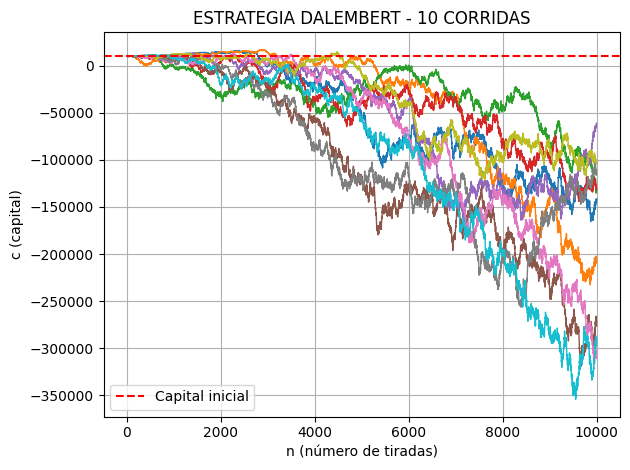

In [120]:
grafico_flujo_caja(corridas)


/home/gonzalo/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


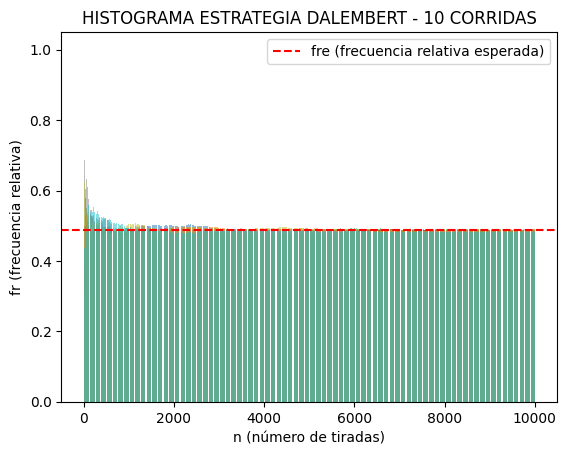

In [121]:
graficar_histograma(corridas)

In [122]:
corridas[0]

,flujo_caja,apuestas,wins,frec_rel
1,10000,5,True,1.000000
2,10005,5,False,0.500000
3,10000,10,False,0.333333
4,9990,15,True,0.500000
5,10005,10,True,0.600000
...,...,...,...,...
9996,-144505,1340,True,0.487995
9997,-143165,1335,True,0.488046
9998,-141830,1330,False,0.487998
9999,-143160,1335,True,0.488049


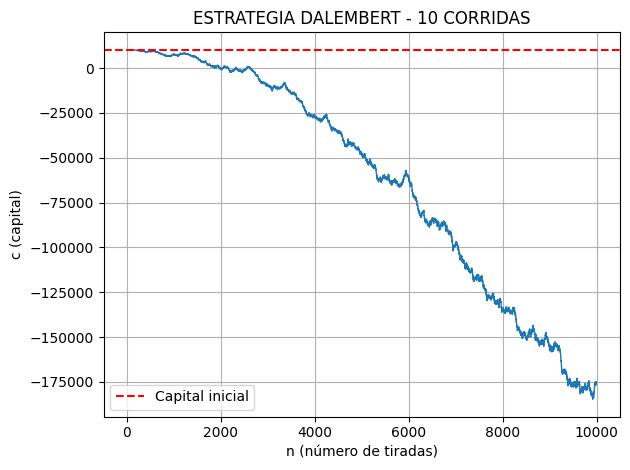

In [123]:
df_promedio_list = []
df_promedio = pd.concat(corridas).groupby(level=0).mean()
df_promedio_list.append(df_promedio)
grafico_flujo_caja(df_promedio_list)


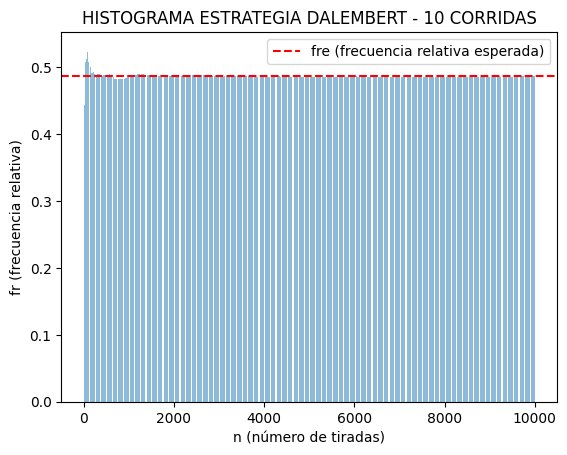

In [124]:
graficar_histograma(df_promedio_list)